# Parte 1: Estadísticas para ingenieros que miran el cielo.

Dadas las señales de temperaturas diarias registradas durante cierto periodo en las tres ciudades (S1: Quito, S2: Melbourne, S3: Oslo), expresadas como valores enteros, en °C (grados centígrados):

1.1 Calcular la temperatura promedio y la desviación estándar para cada señal Si y analizar cómo se comportan estadísticamente.

1.2 Calcular el factor de correlación cruzada entre cada par de señales. Discutir si existen correlaciones significativas o no (tratando de establecer, por ejemplo, si Melbourne podría estar prediciendo el clima de Quito, o de Oslo.. o si no tienen nada que ver).

In [ ]:
import math
import pandas as pd
import numpy as np

In [34]:
#Cargamos los datos de la temperatura de las ciudades en datasets

dataset_melbourne=pd.read_csv("temperature_Melbourne_celsius.csv")
dataset_oslo=pd.read_csv("temperature_Oslo_celsius.csv")
dataset_quito=pd.read_csv("temperature_Quito_celsius.csv")

In [ ]:
def calcular_promedio(dataset):
    sum = 0
    for temperature in dataset["AvgTemperature"]:
        sum = sum + temperature
    return sum / len(dataset["AvgTemperature"])

Promedios de cada ciudad:

In [ ]:
def calcular_desvio_estandar(dataset,promedio):
    sum = 0
    for temperature in dataset["AvgTemperature"]:
        sum += pow(temperature - promedio,2)
    return np.sqrt(sum/len(dataset["AvgTemperature"]-1)) 

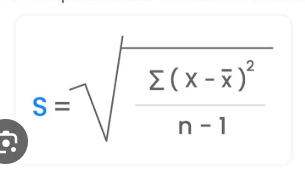

In [ ]:
desvio_oslo